In [1]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Additional Info when using cuda
if device.type == "cuda":
    print(torch.cuda.get_device_name(0))
    print("Memory Usage:")
    print("Allocated:", round(torch.cuda.memory_allocated(0) / 1024**3, 1), "GB")
    print("Cached:   ", round(torch.cuda.memory_reserved(0) / 1024**3, 1), "GB")

# To watch nvidia-smi continuously after every 2 seconds: watch -n 2 nvidia-smi

Using device: cuda
NVIDIA GeForce GTX 1050 Ti
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [2]:
from common.data_pipeline.MMCBNU_6000.dataset import DatasetLoader as mmcbnu
from common.data_pipeline.FV_USM.dataset import DatasetLoader as fvusm
from common.util.data_pipeline.dataset_chainer import DatasetChainer
from common.util.enums import EnvironmentType

environment = EnvironmentType.PYTORCH
datasets = DatasetChainer(
    datasets=[
        mmcbnu(included_portion=1, environment_type=environment),
        fvusm(included_portion=0, environment_type=environment),
    ]
)
train, test, validation = datasets.get_dataset(environment, batch_size=10)

2023-09-08 16:32:31,916 - root - INFO - Preprocessing MMCBNU6000 dataset for train split.
100%|██████████| 4200/4200 [00:00<00:00, 4743.11it/s]
2023-09-08 16:32:32,914 - root - INFO - Preprocessing MMCBNU6000 dataset for test split.
100%|██████████| 1200/1200 [00:00<00:00, 4604.13it/s]
2023-09-08 16:32:33,207 - root - INFO - Preprocessing MMCBNU6000 dataset for validation split.
100%|██████████| 600/600 [00:00<00:00, 4940.08it/s]
2023-09-08 16:32:33,356 - root - INFO - Preprocessing FV_USM dataset for train split.
0it [00:00, ?it/s]
2023-09-08 16:32:33,361 - root - INFO - Preprocessing FV_USM dataset for test split.
0it [00:00, ?it/s]
2023-09-08 16:32:33,363 - root - INFO - Preprocessing FV_USM dataset for validation split.
0it [00:00, ?it/s]
2023-09-08 16:32:33,365 - root - INFO - Concatenating train set
2023-09-08 16:32:33,432 - root - INFO - Concatenating test set
2023-09-08 16:32:33,459 - root - INFO - Concatenating validation set


In [3]:
image, labels = train.dataset.data
print(image.shape, labels.shape)

(4200, 1, 60, 120) (4200, 100)


In [4]:
from common.util.enums import DatasetSplitType


# datasets.get_files(DatasetSplitType.TRAIN)

In [5]:
from common.train_pipeline.isotropic_vig import isotropic_vig_ti_224_gelu

model = isotropic_vig_ti_224_gelu()
model.to("cuda")
print()
# print(model)

c:\Users\sushr\.conda\envs\dl-torch\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


dpr [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
num_knn [9, 9, 10, 11, 12, 13, 13, 14, 15, 16, 17, 18]



In [6]:
import torch.optim as optim
import torch.nn as nn
import torch
from tqdm import tqdm

optimizer = optim.Adam(model.parameters(), lr=0.001)
jsd = None
mixup_active = None

train_loss_fn = nn.CrossEntropyLoss().cuda()
validate_loss_fn = nn.CrossEntropyLoss().cuda()

# Training loop
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    for inputs, labels in tqdm(train, desc=f"Epoch {epoch}: "):
        inputs = inputs.float().to("cuda")
        labels = labels.float().to("cuda")
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = train_loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in validation:
            inputs = inputs.float().to("cuda")
            labels = labels.float().to("cuda")
            outputs = model(inputs)
            val_loss += validate_loss_fn(outputs, labels)
            predicted = (outputs > 0.8).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(
        f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}, Accuracy: {(correct/total)*100:.2f}%"
    )
model.train()

Epoch 0:   0%|          | 0/420 [00:00<?, ?it/s]

Epoch 0: 100%|██████████| 420/420 [00:42<00:00,  9.87it/s]


Epoch [1/20], Loss: 2.1385, Val Loss: 784.8433, Accuracy: 9219.00%


Epoch 1: 100%|██████████| 420/420 [00:39<00:00, 10.62it/s]


Epoch [2/20], Loss: 2.0890, Val Loss: 952.3834, Accuracy: 9224.00%


Epoch 2: 100%|██████████| 420/420 [00:39<00:00, 10.64it/s]


Epoch [3/20], Loss: 2.1149, Val Loss: 932.7479, Accuracy: 9243.33%


Epoch 3: 100%|██████████| 420/420 [00:40<00:00, 10.41it/s]


Epoch [4/20], Loss: 1.9498, Val Loss: 1122.8969, Accuracy: 9201.17%


Epoch 4: 100%|██████████| 420/420 [00:41<00:00, 10.16it/s]


Epoch [5/20], Loss: 1.9690, Val Loss: 947.0005, Accuracy: 9200.00%


Epoch 5: 100%|██████████| 420/420 [00:42<00:00,  9.90it/s]


Epoch [6/20], Loss: 2.0535, Val Loss: 1185.7262, Accuracy: 9200.00%


Epoch 6: 100%|██████████| 420/420 [00:43<00:00,  9.62it/s]


Epoch [7/20], Loss: 2.0012, Val Loss: 1013.3354, Accuracy: 9200.83%


Epoch 7: 100%|██████████| 420/420 [00:43<00:00,  9.73it/s]


Epoch [8/20], Loss: 1.9737, Val Loss: 971.6207, Accuracy: 9204.33%


Epoch 8: 100%|██████████| 420/420 [00:44<00:00,  9.51it/s]


Epoch [9/20], Loss: 1.9730, Val Loss: 1169.0549, Accuracy: 9203.67%


Epoch 9: 100%|██████████| 420/420 [00:44<00:00,  9.50it/s]


Epoch [10/20], Loss: 2.0961, Val Loss: 1413.1934, Accuracy: 9202.00%


Epoch 10: 100%|██████████| 420/420 [00:44<00:00,  9.48it/s]


Epoch [11/20], Loss: 2.0994, Val Loss: 1834.4760, Accuracy: 9200.00%


Epoch 11: 100%|██████████| 420/420 [00:44<00:00,  9.41it/s]


Epoch [12/20], Loss: 2.1390, Val Loss: 1661.8650, Accuracy: 9204.83%


Epoch 12: 100%|██████████| 420/420 [00:45<00:00,  9.31it/s]


Epoch [13/20], Loss: 2.1152, Val Loss: 1686.6022, Accuracy: 9202.00%


Epoch 13: 100%|██████████| 420/420 [00:45<00:00,  9.29it/s]


Epoch [14/20], Loss: 2.0708, Val Loss: 1346.5054, Accuracy: 9202.50%


Epoch 14: 100%|██████████| 420/420 [00:44<00:00,  9.35it/s]


Epoch [15/20], Loss: 2.0423, Val Loss: 1150.4292, Accuracy: 9214.17%


Epoch 15: 100%|██████████| 420/420 [00:45<00:00,  9.31it/s]


Epoch [16/20], Loss: 1.9902, Val Loss: 1118.4386, Accuracy: 9207.67%


Epoch 16: 100%|██████████| 420/420 [00:45<00:00,  9.19it/s]


Epoch [17/20], Loss: 1.9743, Val Loss: 1834.3138, Accuracy: 9203.50%


Epoch 17: 100%|██████████| 420/420 [00:46<00:00,  9.10it/s]


Epoch [18/20], Loss: 1.9390, Val Loss: 1823.7092, Accuracy: 9201.50%


Epoch 18: 100%|██████████| 420/420 [00:45<00:00,  9.21it/s]


Epoch [19/20], Loss: 1.9516, Val Loss: 1219.2723, Accuracy: 9211.00%


Epoch 19: 100%|██████████| 420/420 [00:46<00:00,  9.08it/s]


Epoch [20/20], Loss: 2.0164, Val Loss: 1373.1365, Accuracy: 9232.83%


IsoTropicVIG(
  (stem): Stem(
    (stem): Sequential(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): GELU(approximate='none')
      (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): GELU(approximate='none')
      (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): GELU(approximate='none')
      (9): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (10): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (11): GELU(approximate='none')
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): BatchNorm2d(256, eps=1e-05, mome

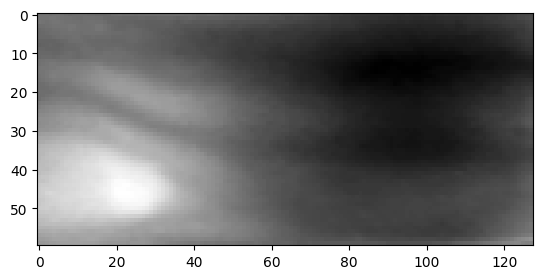

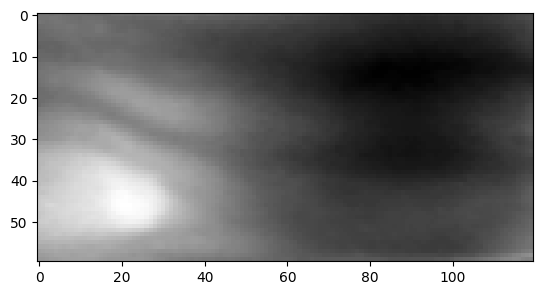

In [13]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

image_path = "./datasets/MMCBNU_6000/ROIs/084/L_Fore/02.bmp"
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
plt.imshow(image, cmap="gray")
plt.show()
res_img = cv2.resize(image, (120, 60))
plt.imshow(res_img, cmap="gray")
plt.show()